## Import packages

In [4]:
#!pip3 install numpy=1.20.2
#!pip3 install pandas=1.2.4
#!pip3 install pillow=8.1.2
#!pip3 install scipy=1.6.3
#!pip3 install rdkit=2022.3.4
#!pip3 install scikit-learn=0.24.2
#!pip3 install matplotlib=3.4.1
#!pip3 install seaborn=0.11.1
#!pip3 install shap=0.41.0

In [5]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import scipy
import multiprocessing
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
multiprocessing.cpu_count()

128

## Define function to prepare data, train/test the ML models and evaluate them

In [10]:
def prepareDataFrame(df, categorical_features):
    
    for ft in categorical_features:
        
        cat_ft = pd.get_dummies(df[ft], prefix='cat')
        df = pd.concat([df,cat_ft], axis=1)
        df = df.drop(ft, 1)
    
        
    print("Dataframe after dummy variables:")
    print(df.shape)

    Y = df[['ba']] 
    Y = Y.values.ravel()
    
    X = df.drop('ba', axis=1)
    
    return X, Y

In [11]:
def evaluate(model, test_features, test_labels, model_type):
    
    predictions = model.predict(test_features)
    
    pred_dict = {'observed':test_labels,'predicted':predictions}
    
    pred_df = pd.DataFrame(pred_dict)
    pred_df.to_csv("work/predictions/"+model_type+".csv", encoding="utf-8", index=False)
    
    pearson_r = scipy.stats.pearsonr(test_labels, predictions)
    print('Pearson R: ', pearson_r)
    print('Pearson R squared: ', pearson_r[0]**2)

    r2 = metrics.r2_score(test_labels, predictions)
    mae = metrics.mean_absolute_error(test_labels, predictions)
    mse = metrics.mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(metrics.mean_squared_error(test_labels, predictions))
    rae = metrics.mean_absolute_error(test_labels, predictions) / metrics.mean_absolute_error(test_labels, [test_labels.mean()] * len(test_labels))
    rrse = np.sqrt(metrics.mean_squared_error(test_labels, predictions)) / np.sqrt(metrics.mean_squared_error(test_labels, [test_labels.mean()] * len(test_labels)))
    
    print('R Squared Error:', r2)
    print('Mean Absolute Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Relative absolute Error:', rae)
    print('Root relateive squared Error:', rrse)
    
    return [r2, mae, mse, rmse, rae, rrse]

In [12]:
def train_test(model_type):
    
    categorical_features = []
    
    if(model_type == "dual_model_pl_split_random"):
     
        train = pd.read_csv("work/training/dual-model/train-random.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-random.csv", sep=",", encoding="utf-8")
        
    elif(model_type == "dual_model_pl_split_protein"):
     
        train = pd.read_csv("work/training/dual-model/train-protein.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-protein.csv", sep=",", encoding="utf-8")
        
    elif(model_type == "dual_model_pl_split_pocket"):
     
        train = pd.read_csv("work/training/dual-model/train-pocket.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-pocket.csv", sep=",", encoding="utf-8")
                
    elif(model_type == "dual_model_pl_split_ligand_weight"):
     
        train = pd.read_csv("work/training/dual-model/train-ligand-weight.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-ligand-weight.csv", sep=",", encoding="utf-8")
        
    elif(model_type == "dual_model_pl_split_ligand_diversity"):
     
        train = pd.read_csv("work/training/dual-model/train-ligand-diversity.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-ligand-diversity.csv", sep=",", encoding="utf-8")
                
    elif(model_type == "dual_model_pl_split_ligand_tpsa"):
     
        train = pd.read_csv("work/training/dual-model/train-ligand-tpsa.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-ligand-tpsa.csv", sep=",", encoding="utf-8")
                
    elif(model_type == "dual_model_pl_split_ligand_volume"):
     
        train = pd.read_csv("work/training/dual-model/train-ligand-volume.csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/dual-model/test-ligand-volume.csv", sep=",", encoding="utf-8")    
        
    print(train.shape)
    print(test.shape)
    
    train_X, train_Y = prepareDataFrame(train, categorical_features)
    test_X, test_Y = prepareDataFrame(test, categorical_features)
    
    train_X = np.array(train_X)

    num_of_features = round(train_X.shape[1]/2)
    
    regressor = RandomForestRegressor(n_jobs=-1, max_features=num_of_features, n_estimators=500, random_state = 123, criterion= 'mse') 

    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    
    RMSE_sum=0
    RMSE_length=5
    MSE_sum=0
    MSE_length=5
    MAE_sum=0
    MAE_length=5
    R2_sum=0
    R2_length=5
    
    for loop_number, (train_k, test_k) in enumerate(kf.split(train_X)):

        ## Get Training Matrix and Y Vector

        training_X_array = train_X[train_k]
        training_y_array = train_Y[train_k].reshape(-1, 1)

        training_y_array = training_y_array.ravel()
        
        ## Get Testing Matrix and Y vector

        X_test_array = train_X[test_k]
        y_actual_values = train_Y[test_k]

        ## Fit the Random Forest Regression Model

        lr_model = regressor.fit(training_X_array, training_y_array)

        ## Compute the predictions for the test data

        prediction = lr_model.predict(X_test_array)      
        predicted_Y = np.array(prediction)   

        ## Calculate the RMSE

        RMSE_cross_fold = np.sqrt(metrics.mean_squared_error(y_actual_values, predicted_Y))
        RMSE_sum = RMSE_cross_fold + RMSE_sum
        
        MSE_cross_fold = metrics.mean_squared_error(y_actual_values, predicted_Y)
        MSE_sum = MSE_cross_fold + MSE_sum
        
        MAE_cross_fold = metrics.mean_absolute_error(y_actual_values, predicted_Y)
        MAE_sum = MAE_cross_fold + MAE_sum
        
        R2_cross_fold = metrics.r2_score(y_actual_values, predicted_Y)
        R2_sum = R2_cross_fold + R2_sum

    ## Calculate the average and print    

    RMSE_cross_fold_avg = RMSE_sum / RMSE_length
    MSE_cross_fold_avg = MSE_sum / MSE_length
    MAE_cross_fold_avg = MAE_sum / MAE_length
    R2_cross_fold_avg = R2_sum / R2_length

    print('The Mean R2 across all folds is: ', R2_cross_fold_avg)
    print('The Mean MAE across all folds is: ', MAE_cross_fold_avg)
    print('The Mean MSE across all folds is: ', MSE_cross_fold_avg)
    print('The Mean RMSE across all folds is: ', RMSE_cross_fold_avg)
    
    # Now, lets train the model on the whole dataset
    
    regressor.fit(train_X, train_Y)
    
    print("Evaluation with the test set: ")
    final_metrics = evaluate(regressor, test_X, test_Y, model_type)
    
    final_metrics = [R2_cross_fold_avg, MAE_cross_fold_avg, MSE_cross_fold_avg, RMSE_cross_fold_avg] + final_metrics
    
    pickle.dump(regressor, open("work/models/"+model_type+".mdl", 'wb'))
    
    return final_metrics, regressor

In [13]:
def train_test_mutation_model(model_type):

    rf_model_ba = pickle.load(open("work/models/dual_model_pl_split_ligand_weight.mdl", 'rb'))

    train_pl = pd.read_csv("work/training/dual-model/train-ligand-weight.csv", sep=",", encoding="utf-8")
    test_pl = pd.read_csv("work/training/dual-model/test-ligand-weight.csv", sep=",", encoding="utf-8")

    train_meta_pl = pd.read_csv("work/training/dual-model/train-meta-ligand-weight.csv", sep=",", encoding="utf-8")
    test_meta_pl = pd.read_csv("work/training/dual-model/test-meta-ligand-weight.csv", sep=",", encoding="utf-8")
        
        
    train_pl = pd.concat([train_meta_pl, train_pl], axis=1)
    test_pl = pd.concat([test_meta_pl, test_pl], axis=1)

    train_test_pl = pd.concat([train_pl, test_pl])
    
    
    pl_Y = train_test_pl[['ba']] 
    pl_Y = pl_Y.values.ravel()
    
    pl_X = train_test_pl.drop(['pdb', 'ligand_file', 'chembl_id', 'tanimoto_index', 'ba'], axis=1)
    
    ba_predictions = rf_model_ba.predict(pl_X)
    
    train_test_pl['predicted_wt_ba'] = ba_predictions
    
    train_test_pl.rename(columns = {'ba':'wt_pl_ba'}, inplace = True)
    
    
    train_mut = pd.read_csv("work/training/dual-model/train-mutations-random.csv", sep=",", encoding="utf-8")
    test_mut = pd.read_csv("work/training/dual-model/test-mutations-random.csv", sep=",", encoding="utf-8")
    
    train_meta_mut = pd.read_csv("work/training/dual-model/train-mutations-meta-random.csv", sep=",", encoding="utf-8")
    test_meta_mut = pd.read_csv("work/training/dual-modelf/test-mutations-meta-random.csv", sep=",", encoding="utf-8")
    
    train_mut = pd.concat([train_meta_mut, train_mut], axis=1)
    test_mut = pd.concat([test_meta_mut, test_mut], axis=1)

    # real wt_ba training
    train_mut_real_ba = train_mut.copy()
    
    train_mut_real_ba_cols = list(train_mut_real_ba.columns.values)
    train_mut_real_ba_cols.pop(train_mut_real_ba_cols.index('FoldXname.x'))
    train_mut_real_ba_cols.pop(train_mut_real_ba_cols.index('ligand_file'))
    train_mut_real_ba_cols.pop(train_mut_real_ba_cols.index('FoldXmutation'))
    train_mut_real_ba = train_mut_real_ba[train_mut_real_ba_cols] 

    # predicted wt_ba train set
    train_mut_predicted_ba = train_mut.merge(train_test_pl[['ligand_file', 'predicted_wt_ba']], on='ligand_file', how='left')
    
    train_mut_predicted_ba_cols = list(train_mut_predicted_ba.columns.values)
    train_mut_predicted_ba_cols.pop(train_mut_predicted_ba_cols.index('FoldXname.x'))
    train_mut_predicted_ba_cols.pop(train_mut_predicted_ba_cols.index('ligand_file'))
    train_mut_predicted_ba_cols.pop(train_mut_predicted_ba_cols.index('FoldXmutation'))
    train_mut_predicted_ba_cols.pop(train_mut_predicted_ba_cols.index('wt_ba'))
    train_mut_predicted_ba_cols.pop(train_mut_predicted_ba_cols.index('ba'))
    train_mut_predicted_ba = train_mut_predicted_ba[train_mut_predicted_ba_cols + ['ba']] 
     
    # real wt_ba test set
    test_mut_real_ba = test_mut.copy()
    
    test_mut_real_ba_cols = list(test_mut_real_ba.columns.values)
    test_mut_real_ba_cols.pop(test_mut_real_ba_cols.index('FoldXname.x'))
    test_mut_real_ba_cols.pop(test_mut_real_ba_cols.index('ligand_file'))
    test_mut_real_ba_cols.pop(test_mut_real_ba_cols.index('FoldXmutation'))
    test_mut_real_ba = test_mut_real_ba[test_mut_real_ba_cols] 
    
    # predicted wt_ba test set
    test_mut_predicted_ba = test_mut.merge(train_test_pl[['ligand_file', 'predicted_wt_ba']], on='ligand_file', how='left')
    
    test_mut_predicted_ba_cols = list(test_mut_predicted_ba.columns.values)
    test_mut_predicted_ba_cols.pop(test_mut_predicted_ba_cols.index('FoldXname.x'))
    test_mut_predicted_ba_cols.pop(test_mut_predicted_ba_cols.index('ligand_file'))
    test_mut_predicted_ba_cols.pop(test_mut_predicted_ba_cols.index('FoldXmutation'))
    test_mut_predicted_ba_cols.pop(test_mut_predicted_ba_cols.index('wt_ba'))
    test_mut_predicted_ba_cols.pop(test_mut_predicted_ba_cols.index('ba'))
    test_mut_predicted_ba = test_mut_predicted_ba[test_mut_predicted_ba_cols + ['ba']] 
    

    categorical_features = []
    
    print(train_mut_real_ba.shape)
    print(test_mut_real_ba.shape)
    
    train_real_X, train_real_Y = prepareDataFrame(train_mut_real_ba, categorical_features)
    train_pred_X, train_pred_Y = prepareDataFrame(train_mut_predicted_ba, categorical_features)

    test_real_X, test_real_Y = prepareDataFrame(test_mut_real_ba, categorical_features)
    test_pred_X, test_pred_Y = prepareDataFrame(test_mut_predicted_ba, categorical_features)

    num_of_features = round(train_real_X.shape[1]/2)
    
    regressor = RandomForestRegressor(n_jobs=-1, max_features=num_of_features, n_estimators=500, random_state = 123, criterion= 'mse') 

    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    
    RMSE_sum=0
    RMSE_length=5
    MSE_sum=0
    MSE_length=5
    MAE_sum=0
    MAE_length=5
    R2_sum=0
    R2_length=5
    
    if(model_type == "mutation_model_real_wt_ba"):
        train_X = np.array(train_real_X)
        train_Y = train_real_Y
    elif(model_type == "mutation_model_pred_wt_ba"):
        train_X = np.array(train_pred_X)
        train_Y = train_pred_Y
    
    for loop_number, (train_k, test_k) in enumerate(kf.split(train_X)):

        ## Get Training Matrix and Y Vector

        training_X_array = train_X[train_k]
        training_y_array = train_Y[train_k].reshape(-1, 1)

        training_y_array = training_y_array.ravel()
        
        ## Get Testing Matrix and Y vector

        X_test_array = train_X[test_k]
        y_actual_values = train_Y[test_k]

        ## Fit the Random Forest Regression Model

        lr_model = regressor.fit(training_X_array, training_y_array)

        ## Compute the predictions for the test data

        prediction = lr_model.predict(X_test_array)      
        predicted_Y = np.array(prediction)   

        ## Calculate the RMSE

        RMSE_cross_fold = np.sqrt(metrics.mean_squared_error(y_actual_values, predicted_Y))
        RMSE_sum = RMSE_cross_fold + RMSE_sum
        
        MSE_cross_fold = metrics.mean_squared_error(y_actual_values, predicted_Y)
        MSE_sum = MSE_cross_fold + MSE_sum
        
        MAE_cross_fold = metrics.mean_absolute_error(y_actual_values, predicted_Y)
        MAE_sum = MAE_cross_fold + MAE_sum
        
        R2_cross_fold = metrics.r2_score(y_actual_values, predicted_Y)
        R2_sum = R2_cross_fold + R2_sum

    ## Calculate the average and print    

    RMSE_cross_fold_avg = RMSE_sum / RMSE_length
    MSE_cross_fold_avg = MSE_sum / MSE_length
    MAE_cross_fold_avg = MAE_sum / MAE_length
    R2_cross_fold_avg = R2_sum / R2_length

    print('The Mean R2 across all folds is: ', R2_cross_fold_avg)
    print('The Mean MAE across all folds is: ', MAE_cross_fold_avg)
    print('The Mean MSE across all folds is: ', MSE_cross_fold_avg)
    print('The Mean RMSE across all folds is: ', RMSE_cross_fold_avg)
    print('\n')
    
    # Now, lets train the model on the whole dataset
    
    regressor.fit(train_X, train_Y)
    
    print("Evaluation with the test set (real wt_bt): ")
    final_metrics_real = evaluate(regressor, test_real_X, test_real_Y, model_type+"_test_real_wt_ba")
    
    final_metrics_real = [R2_cross_fold_avg, MAE_cross_fold_avg, MSE_cross_fold_avg, RMSE_cross_fold_avg] + final_metrics_real
    
    print('\n')
    print("Evaluation with the test set (predicted wt_bt): ")
    final_metrics_pred = evaluate(regressor, test_pred_X, test_pred_Y, model_type+"_test_pred_wt_ba")
    
    final_metrics_pred = [R2_cross_fold_avg, MAE_cross_fold_avg, MSE_cross_fold_avg, RMSE_cross_fold_avg] + final_metrics_pred
    
    pickle.dump(regressor, open("work/models/"+model_type+".mdl", 'wb'))
    
    return final_metrics_real, final_metrics_pred, regressor

In [14]:
def train_test_y_randomization():
    
    for i in range(1,11):
        
        train = pd.read_csv("work/training/randomization/randomization_y"+str(i)+".csv", sep=",", encoding="utf-8")
        test = pd.read_csv("work/training/randomization/randomization_y"+str(i)+".csv", sep=",", encoding="utf-8") 
        
        print(train.shape)
        print(test.shape)

        categorical_features = []

        train_Y = train[['y_scramble_'+str(i)]] 
        train_Y = train_Y.values.ravel()
        train_X = train.drop('y_scramble_'+str(i), axis=1)
        
        test_Y = test[['y_scramble_'+str(i)]] 
        test_Y = test_Y.values.ravel()
        test_X = test.drop('y_scramble_'+str(i), axis=1)
        

        train_X = np.array(train_X)

        num_of_features = round(train_X.shape[1]/2)

        regressor = RandomForestRegressor(n_jobs=-1, max_features=num_of_features, n_estimators=500, random_state = 123, criterion= 'squared_error') 

        kf = KFold(n_splits=5, random_state=123, shuffle=True)

        RMSE_sum=0
        RMSE_length=5
        MSE_sum=0
        MSE_length=5
        MAE_sum=0
        MAE_length=5
        R2_sum=0
        R2_length=5

        for loop_number, (train_k, test_k) in enumerate(kf.split(train_X)):

            ## Get Training Matrix and Y Vector

            training_X_array = train_X[train_k]
            training_y_array = train_Y[train_k].reshape(-1, 1)

            training_y_array = training_y_array.ravel()

            ## Get Testing Matrix and Y vector

            X_test_array = train_X[test_k]
            y_actual_values = train_Y[test_k]

            ## Fit the Random Forest Regression Model

            lr_model = regressor.fit(training_X_array, training_y_array)

            ## Compute the predictions for the test data

            prediction = lr_model.predict(X_test_array)      
            predicted_Y = np.array(prediction)   

            ## Calculate the RMSE

            RMSE_cross_fold = np.sqrt(metrics.mean_squared_error(y_actual_values, predicted_Y))
            RMSE_sum = RMSE_cross_fold + RMSE_sum

            MSE_cross_fold = metrics.mean_squared_error(y_actual_values, predicted_Y)
            MSE_sum = MSE_cross_fold + MSE_sum

            MAE_cross_fold = metrics.mean_absolute_error(y_actual_values, predicted_Y)
            MAE_sum = MAE_cross_fold + MAE_sum

            R2_cross_fold = metrics.r2_score(y_actual_values, predicted_Y)
            R2_sum = R2_cross_fold + R2_sum

        ## Calculate the average and print    

        RMSE_cross_fold_avg = RMSE_sum / RMSE_length
        MSE_cross_fold_avg = MSE_sum / MSE_length
        MAE_cross_fold_avg = MAE_sum / MAE_length
        R2_cross_fold_avg = R2_sum / R2_length

        print('The Mean R2 across all folds is: ', R2_cross_fold_avg)
        print('The Mean MAE across all folds is: ', MAE_cross_fold_avg)
        print('The Mean MSE across all folds is: ', MSE_cross_fold_avg)
        print('The Mean RMSE across all folds is: ', RMSE_cross_fold_avg)
        print('\n')

In [15]:
def get_df_feature_importance(importance,names,model_type, top=20, execlude=None):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    ft_df = pd.DataFrame(data)

    ft_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    ft_df = ft_df.iloc[0:top]
    
    if(execlude is not None):
        ft_df = ft_df[ft_df.feature_names != execlude]

    return ft_df

## Train/Test a Ranadom Forest model to predict binding affinity for mutated protein-ligand using features of the protein, binding-site, ligand and mutation

In the first approach in the paper, a single model was proposed to predict the binding affinity of protein-ligand binding pair whether the protein is wild-type (WT) or has a single point mutation in the binding site using features for the protein, binding-site, ligand and the mutation. This way, the mutation effect on binding affinity can be assessed by predicting the binding affinity of the ligand to the WT protein and the mutated one and comparing them.

In [164]:
final_metrics_df = pd.DataFrame()

In [165]:
final_metrics_df.shape

(0, 0)

In [166]:
final_metrics_df['metric'] = ["R2 (5-fold cross-validation)", "MAE (5-fold cross-validation)", "MSE (5-fold cross-validation)", "RMSE (5-fold cross-validation)",
                              "R2 (test set)", "MAE (test set)", "MSE (test set)", "RMSE (test set)", 
                              "Relative absolute error (test set)", "Root relative squared error (test set)"]

In [168]:
final_metrics_df.shape

(10, 1)

In [169]:
final_metrics, reg_model = train_test("first_approach_balanced")

(317513, 270)
(79377, 270)
Dataframe after dummy variables:
(317513, 270)
Dataframe after dummy variables:
(79377, 270)
The Mean R2 across all folds is:  0.9674841475754506
The Mean MAE across all folds is:  0.14910921594414198
The Mean MSE across all folds is:  0.07856928143788036
The Mean RMSE across all folds is:  0.28029729715978957
Evaluation with the test set: 
Pearson R:  (0.9841602913760498, 0.0)
Pearson R squared:  0.9685714791213912
R Squared Error: 0.9685653947975986
Mean Absolute Error: 0.14507822669035242
Mean Squared Error: 0.07599557207856177
Root Mean Squared Error: 0.275672944045225
Relative absolute Error: 0.11333937338183776
Root relateive squared Error: 0.17729806880618137


In [170]:
final_metrics_df['balanced'] = pd.Series(final_metrics)

In [ ]:
final_metrics, reg_model = train_test("first_approach_unbalanced")

(847815, 278)
(211953, 278)
Dataframe after dummy variables:
(847815, 278)
Dataframe after dummy variables:
(211953, 278)


In [ ]:
final_metrics_df['unbalanced'] = pd.Series(final_metrics)

In [7]:
final_metrics_df.head(n=10)

,metric,balanced,unbalanced
0,R2 (5-fold cross-validation),0.967484,0.969750
1,MAE (5-fold cross-validation),0.149109,0.138096
2,MSE (5-fold cross-validation),0.078569,0.068015
3,RMSE (5-fold cross-validation),0.280297,0.260795
4,R2 (test set),0.968565,0.970790
5,MAE (test set),0.145078,0.133028
6,MSE (test set),0.075996,0.065428
7,RMSE (test set),0.275673,0.255790
8,Relative absolute error (test set),0.113339,0.111730
9,Root relative squared error (test set),0.177298,0.170910


In [ ]:
final_metrics_df.to_csv("work/training/first-approach/final_metrics.csv", sep=",", index=False, encoding="utf-8")

## Train/Test a Random Forest model to predict binding affinity from protein, binding-site and ligand features

In the dual model approach in the paper, a separate model was proposed to predict the binding affinity of wild-type (WT) protein-ligand pairs. Then, another model will be developed to use the predicted WT protein-ligand binding affinity besides mutation features to predict the binding affinity of mutated protein-ligand pair.
The below is to train/test a model to predict WT protein-ligand binding affinity using protein, binding-site and ligand featues. Different splitting scenarios were tested for this model (split by protein similarity, binding pocket similarity, ligand similarity and stratified random splitting by binding affinity, ligand molecular weight, ligand surface area and ligand volume)

In [146]:
final_metrics_df = pd.DataFrame()

In [147]:
final_metrics_df.shape

(0, 0)

In [148]:
final_metrics_df['metric'] = ["R2 (5-fold cross-validation)", "MAE (5-fold cross-validation)", "MSE (5-fold cross-validation)", "RMSE (5-fold cross-validation)",
                              "R2 (test set)", "MAE (test set)", "MSE (test set)", "RMSE (test set)", 
                              "Relative absolute error (test set)", "Root relative squared error (test set)"]

In [149]:
final_metrics_df.shape

(10, 1)

In [150]:
final_metrics, reg_model = train_test("dual_model_pl_split_random")

(6738, 126)
(1683, 126)
Dataframe after dummy variables:
(6738, 126)
Dataframe after dummy variables:
(1683, 126)
The Mean R2 across all folds is:  0.8509576779588084
The Mean MAE across all folds is:  0.4197126871011304
The Mean MSE across all folds is:  0.33699007424893235
The Mean RMSE across all folds is:  0.580365995865205
Evaluation with the test set: 
Pearson R:  (0.9321436427463227, 0.0)
Pearson R squared:  0.868891770712384
R Squared Error: 0.8671290619537905
Mean Absolute Error: 0.40136244800950693
Mean Squared Error: 0.30246556922162887
Root Mean Squared Error: 0.5499686984016716
Relative absolute Error: 0.326883818580622
Root relateive squared Error: 0.36451466094823887


In [151]:
final_metrics_df['random_split'] = pd.Series(final_metrics)

In [152]:
final_metrics, reg_model = train_test("dual_model_pl_split_pocket")

(6969, 126)
(1452, 126)
Dataframe after dummy variables:
(6969, 126)
Dataframe after dummy variables:
(1452, 126)
The Mean R2 across all folds is:  0.8692430070804479
The Mean MAE across all folds is:  0.4063900384892287
The Mean MSE across all folds is:  0.3172436039732673
The Mean RMSE across all folds is:  0.5631445867101779
Evaluation with the test set: 
Pearson R:  (0.5318876117837603, 7.726084104267749e-107)
Pearson R squared:  0.2829044315690321
R Squared Error: 0.2485707648145905
Mean Absolute Error: 0.8591214876033066
Mean Squared Error: 1.1148497339393952
Root Mean Squared Error: 1.0558644486577788
Relative absolute Error: 0.8500956445633928
Root relateive squared Error: 0.8668501803572572


In [153]:
final_metrics_df['pocket_split'] = pd.Series(final_metrics)

In [154]:
final_metrics, reg_model = train_test("dual_model_pl_split_protein")

(6731, 126)
(1690, 126)
Dataframe after dummy variables:
(6731, 126)
Dataframe after dummy variables:
(1690, 126)
The Mean R2 across all folds is:  0.8610701844281682
The Mean MAE across all folds is:  0.4143660251221414
The Mean MSE across all folds is:  0.3267372232559859
The Mean RMSE across all folds is:  0.5715057123852781
Evaluation with the test set: 
Pearson R:  (0.7200352715281191, 3.795990719058383e-270)
Pearson R squared:  0.5184507922445721
R Squared Error: 0.4152196084128633
Mean Absolute Error: 0.7777157396449698
Mean Squared Error: 1.0045361886863893
Root Mean Squared Error: 1.002265528034557
Relative absolute Error: 0.7472472252495457
Root relateive squared Error: 0.7647093510525007


In [155]:
final_metrics_df['protein_split'] = pd.Series(final_metrics)

In [156]:
final_metrics, reg_model = train_test("dual_model_pl_split_ligand_diversity")

(6737, 126)
(1684, 126)
Dataframe after dummy variables:
(6737, 126)
Dataframe after dummy variables:
(1684, 126)
The Mean R2 across all folds is:  0.8652961606230015
The Mean MAE across all folds is:  0.39896914799124994
The Mean MSE across all folds is:  0.30062893179847083
The Mean RMSE across all folds is:  0.5480166140975424
Evaluation with the test set: 
Pearson R:  (0.8973566286085314, 0.0)
Pearson R squared:  0.8052489189076697
R Squared Error: 0.8045853343982321
Mean Absolute Error: 0.47772161520190015
Mean Squared Error: 0.4598789959619957
Root Mean Squared Error: 0.6781437870850073
Relative absolute Error: 0.38495807949821514
Root relateive squared Error: 0.44205731031368317


In [157]:
final_metrics_df['ligand_diversity_split'] = pd.Series(final_metrics)

In [158]:
final_metrics, reg_model = train_test("dual_model_pl_split_ligand_weight")

(6770, 126)
(1651, 126)
Dataframe after dummy variables:
(6770, 126)
Dataframe after dummy variables:
(1651, 126)
The Mean R2 across all folds is:  0.8520771745184981
The Mean MAE across all folds is:  0.41659497784342686
The Mean MSE across all folds is:  0.33222098626883306
The Mean RMSE across all folds is:  0.5761344038141452
Evaluation with the test set: 
Pearson R:  (0.9311295929536413, 0.0)
Pearson R squared:  0.8670023188740137
R Squared Error: 0.8664236759625299
Mean Absolute Error: 0.4067153240460329
Mean Squared Error: 0.31206524140520975
Root Mean Squared Error: 0.5586279991239338
Relative absolute Error: 0.3264477856115103
Root relateive squared Error: 0.3654809489391618


In [159]:
final_metrics_df['ligand_weight_split'] = pd.Series(final_metrics)

In [139]:
final_metrics, reg_model = train_test("dual_model_pl_split_ligand_tpsa")

(6765, 126)
(1656, 126)
Dataframe after dummy variables:
(6765, 126)
Dataframe after dummy variables:
(1656, 126)
The Mean R2 across all folds is:  0.8566582183015944
The Mean MAE across all folds is:  0.41469626016260175
The Mean MSE across all folds is:  0.3264438738861791
The Mean RMSE across all folds is:  0.5711376396596861
Evaluation with the test set: 
Pearson R:  (0.9177243839503039, 0.0)
Pearson R squared:  0.8422180448969647
R Squared Error: 0.8411442943636551
Mean Absolute Error: 0.42402499999999976
Mean Squared Error: 0.35141057876811554
Root Mean Squared Error: 0.5927989362069702
Relative absolute Error: 0.35405314875615723
Root relateive squared Error: 0.3985670654185376


In [140]:
final_metrics, reg_model = train_test("dual_model_pl_split_ligand_volume")

(6770, 126)
(1651, 126)
Dataframe after dummy variables:
(6770, 126)
Dataframe after dummy variables:
(1651, 126)
The Mean R2 across all folds is:  0.8505307591558356
The Mean MAE across all folds is:  0.4184301033973414
The Mean MSE across all folds is:  0.3347123998641065
The Mean RMSE across all folds is:  0.5784778733404837
Evaluation with the test set: 
Pearson R:  (0.9322320187915425, 0.0)
Pearson R squared:  0.8690565368601548
R Squared Error: 0.8675394216068888
Mean Absolute Error: 0.40391338582677144
Mean Squared Error: 0.3138169781950334
Root Mean Squared Error: 0.560193697032583
Relative absolute Error: 0.32776083315426835
Root relateive squared Error: 0.36395134069420776


In [160]:
final_metrics_df.shape

(10, 6)

In [162]:
final_metrics_df.head(n=10)

,metric,random_split,pocket_split,protein_split,ligand_diversity_split,ligand_weight_split
0,R2 (5-fold cross-validation),0.850958,0.869243,0.861070,0.865296,0.852077
1,MAE (5-fold cross-validation),0.419713,0.406390,0.414366,0.398969,0.416595
2,MSE (5-fold cross-validation),0.336990,0.317244,0.326737,0.300629,0.332221
3,RMSE (5-fold cross-validation),0.580366,0.563145,0.571506,0.548017,0.576134
4,R2 (test set),0.867129,0.248571,0.415220,0.804585,0.866424
5,MAE (test set),0.401362,0.859121,0.777716,0.477722,0.406715
6,MSE (test set),0.302466,1.114850,1.004536,0.459879,0.312065
7,RMSE (test set),0.549969,1.055864,1.002266,0.678144,0.558628
8,Relative absolute error (test set),0.326884,0.850096,0.747247,0.384958,0.326448
9,Root relative squared error (test set),0.364515,0.866850,0.764709,0.442057,0.365481


In [163]:
final_metrics_df.to_csv("work/training/dual-model/final_metrics.csv", sep=",", index=False, encoding="utf-8")

## Train/Test a Random Forest model to predict binding affinity of mutated protein-ligand from the WT protein-ligand binding affinity and mutation features

In [8]:
final_metrics_df = pd.DataFrame()

In [9]:
final_metrics_df.shape

(0, 0)

In [10]:
final_metrics_df['metric'] = ["R2 (5-fold cross-validation)", "MAE (5-fold cross-validation)", "MSE (5-fold cross-validation)", "RMSE (5-fold cross-validation)",
                              "R2 (test set)", "MAE (test set)", "MSE (test set)", "RMSE (test set)", 
                              "Relative absolute error (test set)", "Root relative squared error (test set)"]

In [11]:
final_metrics_df.shape

(10, 1)

In [12]:
final_metrics_real, final_metrics_pred, reg_model = train_test_mutation_model("mutation_model_real_wt_ba")

(158341, 190)
(39584, 190)
Dataframe after dummy variables:
(158341, 190)
Dataframe after dummy variables:
(158341, 190)
Dataframe after dummy variables:
(39584, 190)
Dataframe after dummy variables:
(39584, 190)
The Mean R2 across all folds is:  0.8963458018916505
The Mean MAE across all folds is:  0.352762619785875
The Mean MSE across all folds is:  0.2465786485365496
The Mean RMSE across all folds is:  0.4965565693027725


Evaluation with the test set (real wt_bt): 
Pearson R:  (0.9469612802175152, 0.0)
Pearson R squared:  0.8967356662311954
R Squared Error: 0.896511085074408
Mean Absolute Error: 0.34941937098092185
Mean Squared Error: 0.24506832485284885
Root Mean Squared Error: 0.4950437605432967
Relative absolute Error: 0.27593320775644575
Root relateive squared Error: 0.32169693023961543


Evaluation with the test set (predicted wt_bt): 
Pearson R:  (0.9409324405702544, 0.0)
Pearson R squared:  0.8853538577174953
R Squared Error: 0.8850130867815884
Mean Absolute Error: 0.3782065

In [13]:
final_metrics_df['mutation_model_real_wt_ba_test_real_wt_ba'] = pd.Series(final_metrics_real)
final_metrics_df['mutation_model_real_wt_ba_test_pred_wt_ba'] = pd.Series(final_metrics_pred)

In [14]:
final_metrics_real, final_metrics_pred, reg_model = train_test_mutation_model("mutation_model_pred_wt_ba")

(158341, 190)
(39584, 190)
Dataframe after dummy variables:
(158341, 190)
Dataframe after dummy variables:
(158341, 190)
Dataframe after dummy variables:
(39584, 190)
Dataframe after dummy variables:
(39584, 190)
The Mean R2 across all folds is:  0.8824172767872792
The Mean MAE across all folds is:  0.38214091719493015
The Mean MSE across all folds is:  0.27971359342825824
The Mean RMSE across all folds is:  0.5288727839178008


Evaluation with the test set (real wt_bt): 
Pearson R:  (0.9341108179070892, 0.0)
Pearson R squared:  0.8725630201310511
R Squared Error: 0.8655399916211797
Mean Absolute Error: 0.39980744746354147
Mean Squared Error: 0.3184098416413948
Root Mean Squared Error: 0.564278159812512
Relative absolute Error: 0.31572420027496156
Root relateive squared Error: 0.3666878895993435


Evaluation with the test set (predicted wt_bt): 
Pearson R:  (0.9399625736993191, 0.0)
Pearson R squared:  0.883529639955448
R Squared Error: 0.8828514632313114
Mean Absolute Error: 0.3810855

In [15]:
final_metrics_df['mutation_model_pred_wt_ba_test_real_wt_ba'] = pd.Series(final_metrics_real)
final_metrics_df['mutation_model_pred_wt_ba_test_pred_wt_ba'] = pd.Series(final_metrics_pred)

In [16]:
final_metrics_df.shape

(10, 5)

In [21]:
final_metrics_df.head(n=10)

,metric,mutation_model_real_wt_ba_test_real_wt_ba,mutation_model_real_wt_ba_test_pred_wt_ba,mutation_model_pred_wt_ba_test_real_wt_ba,mutation_model_pred_wt_ba_test_pred_wt_ba
0,R2 (5-fold cross-validation),0.896346,0.896346,0.882417,0.882417
1,MAE (5-fold cross-validation),0.352763,0.352763,0.382141,0.382141
2,MSE (5-fold cross-validation),0.246579,0.246579,0.279714,0.279714
3,RMSE (5-fold cross-validation),0.496557,0.496557,0.528873,0.528873
4,R2 (test set),0.896511,0.885013,0.865540,0.882851
5,MAE (test set),0.349419,0.378207,0.399807,0.381086
6,MSE (test set),0.245068,0.272296,0.318410,0.277415
7,RMSE (test set),0.495044,0.521820,0.564278,0.526702
8,Relative absolute error (test set),0.275933,0.298666,0.315724,0.300940
9,Root relative squared error (test set),0.321697,0.339097,0.366688,0.342270


In [18]:
final_metrics_df.to_csv("work/training/dual-model/final_metrics_mutation.csv", sep=",", index=False, encoding="utf-8")

# Y-randomization test

In [20]:
train_test_y_randomization()

(6770, 126)
(6770, 126)
The Mean R2 across all folds is:  -0.07256870182450789
The Mean MAE across all folds is:  1.2487744756277694
The Mean MSE across all folds is:  2.4124579176720826
The Mean RMSE across all folds is:  1.553005686232836


(6770, 126)
(6770, 126)
The Mean R2 across all folds is:  -0.07905331690022481
The Mean MAE across all folds is:  1.2574497193500742
The Mean MSE across all folds is:  2.427963054871492
The Mean RMSE across all folds is:  1.5578052826916586


(6770, 126)
(6770, 126)
The Mean R2 across all folds is:  -0.07719008547442359
The Mean MAE across all folds is:  1.2503636632200885
The Mean MSE across all folds is:  2.4218693326203837
The Mean RMSE across all folds is:  1.5556610343343893


(6770, 126)
(6770, 126)
The Mean R2 across all folds is:  -0.06532529466173091
The Mean MAE across all folds is:  1.2405533825701627
The Mean MSE across all folds is:  2.3934215508774006
The Mean RMSE across all folds is:  1.5470127139273615


(6770, 126)
(6770, 126)
Th

# Feature Importance

### Wild-type protein-ligand binding affinity prediction random forest

In [45]:
rf = pickle.load(open("work/models/dual_model_pl_split_ligand_weight.mdl", 'rb'))

In [46]:
train = pd.read_csv("work/training/dual-model/train-ligand-weight.csv", sep=",", encoding="utf-8")
test = pd.read_csv("work/training/dual-model/test-ligand-weight.csv", sep=",", encoding="utf-8") 

print(train.shape)
print(test.shape)

train_X = train.drop('ba', axis=1)
wt_pl_train_X = train_X

test_X = test.drop('ba', axis=1)
wt_pl_test_X = test_X

(6770, 126)
(1651, 126)


In [47]:
wt_pl_ft_df = get_df_feature_importance(rf.feature_importances_,train_X.columns,'WT protein-ligand binding affinity RF model ', top=20)

### Mutated protein-ligand binding affinity prediction random forest (real WT BA)

In [18]:
rf = pickle.load(open("work/models/mutation_model_real_wt_ba.mdl", 'rb'))

In [20]:
train = pd.read_csv("work/training/dual-model/train-mutations-random.csv", sep=",", encoding="utf-8")
test = pd.read_csv("work/training/dual-model/test-mutations-random.csv", sep=",", encoding="utf-8") 

print(train.shape)
print(test.shape)

train_X = train.drop('ba', axis=1)

test_X = test.drop('ba', axis=1)

(158341, 190)
(39584, 190)


In [21]:
mut_real_wt_ba_ft_df = get_df_feature_importance(rf.feature_importances_,train_X.columns,'Mutation protein-ligand binding affinity RF model (real WT BA) ', top=10)

In [22]:
mut_real_no_wt_ba_ft_df = get_df_feature_importance(rf.feature_importances_,train_X.columns,'Mutation protein-ligand binding affinity RF model (real WT BA) ', top=10, execlude="wt_ba")

### Mutated protein-ligand binding affinity prediction random forest (predicted WT BA)

In [23]:
rf = pickle.load(open("work/models/mutation_model_pred_wt_ba.mdl", 'rb'))

In [24]:
train = pd.read_csv("work/training/dual-model/train-mutations-random.csv", sep=",", encoding="utf-8")
test = pd.read_csv("work/training/dual-model/test-mutations-random.csv", sep=",", encoding="utf-8") 

print(train.shape)
print(test.shape)

train_X = train.drop('ba', axis=1)

test_X = test.drop('ba', axis=1)

(158341, 190)
(39584, 190)


In [25]:
mut_pred_wt_ba_ft_df = get_df_feature_importance(rf.feature_importances_,train_X.columns,'Mutation protein-ligand binding affinity RF model (predicted WT BA) ', top=10)

In [26]:
mut_pred_no_wt_ba_ft_df = get_df_feature_importance(rf.feature_importances_,train_X.columns,'Mutation protein-ligand binding affinity RF model (predicted WT BA) ', top=10, execlude="wt_ba")

### Making the feature importance plot

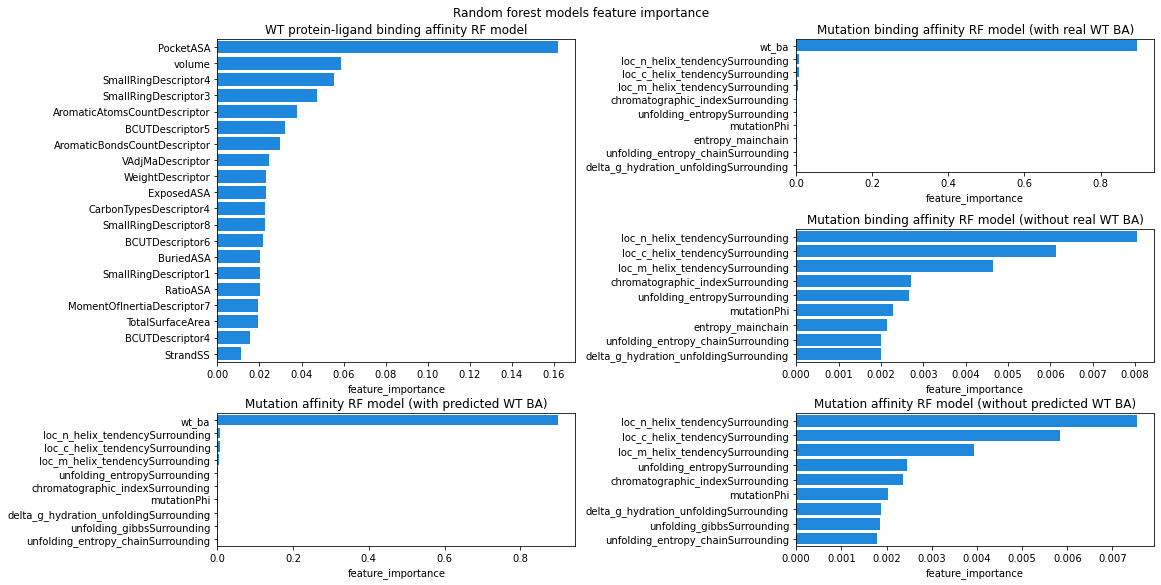

In [63]:
fig, axes = plt.subplot_mosaic([['left', 'right1'], ['left', 'right2'], ['bottom1', 'bottom2']],
                              constrained_layout=True, figsize=(16,8))
fig.suptitle('Random forest models feature importance')

axes['left'].set_title('WT protein-ligand binding affinity RF model')
axes['right1'].set_title('Mutation binding affinity RF model (with real WT BA)')
axes['right2'].set_title('Mutation binding affinity RF model (without real WT BA)')
axes['bottom1'].set_title('Mutation affinity RF model (with predicted WT BA)')
axes['bottom2'].set_title('Mutation affinity RF model (without predicted WT BA)')

sns.barplot(ax=axes['left'], x=wt_pl_ft_df['feature_importance'], y=wt_pl_ft_df['feature_names'], color="#008bfb").set(ylabel=None)
sns.barplot(ax=axes['right1'], x=mut_real_wt_ba_ft_df['feature_importance'], y=mut_real_wt_ba_ft_df['feature_names'], color="#008bfb").set(ylabel=None)
sns.barplot(ax=axes['right2'], x=mut_real_no_wt_ba_ft_df['feature_importance'], y=mut_real_no_wt_ba_ft_df['feature_names'], color="#008bfb").set(ylabel=None)
sns.barplot(ax=axes['bottom1'], x=mut_pred_wt_ba_ft_df['feature_importance'], y=mut_pred_wt_ba_ft_df['feature_names'], color="#008bfb").set(ylabel=None)
sns.barplot(ax=axes['bottom2'], x=mut_pred_no_wt_ba_ft_df['feature_importance'], y=mut_pred_no_wt_ba_ft_df['feature_names'], color="#008bfb").set(ylabel=None)

plt.savefig('images/importance/feature_importance_all.png', dpi=300)

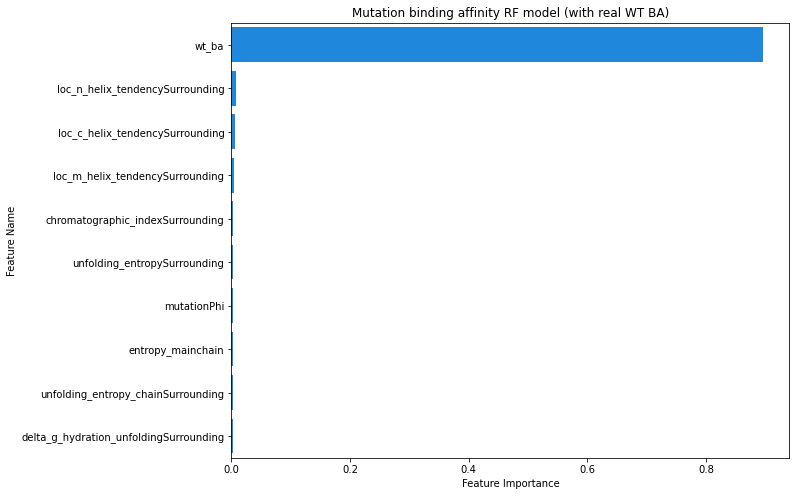

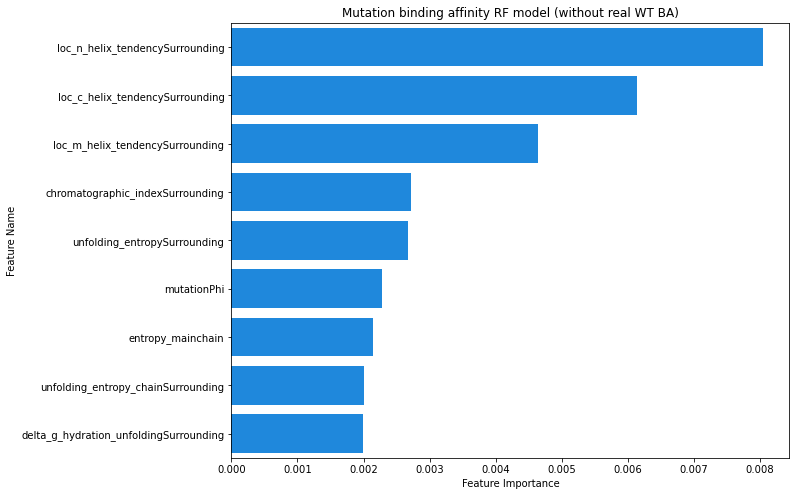

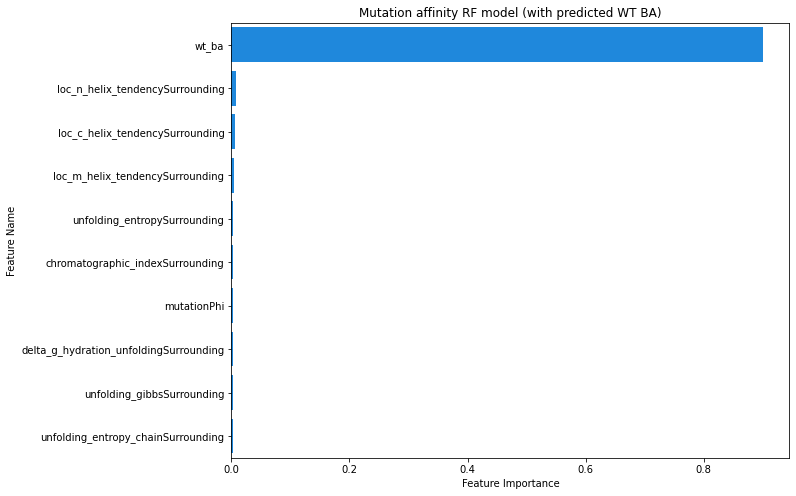

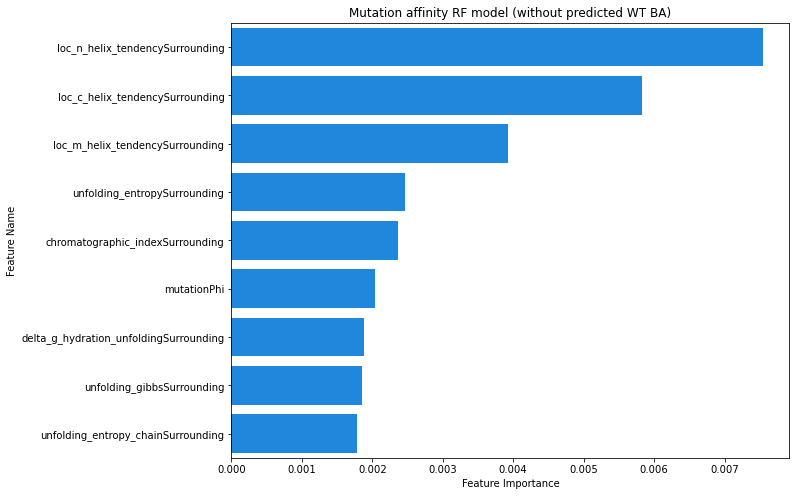

In [114]:
dfs = [mut_real_wt_ba_ft_df, mut_real_no_wt_ba_ft_df, mut_pred_wt_ba_ft_df, mut_pred_no_wt_ba_ft_df]
titles = ['Mutation binding affinity RF model (with real WT BA)',
          'Mutation binding affinity RF model (without real WT BA)',
          'Mutation affinity RF model (with predicted WT BA)',
          'Mutation affinity RF model (without predicted WT BA)']
filenames = ['mut_model_real_wt_ba_feature_importance',
             'mut_model_real_wt_ba_feature_importance_no_wtba',
             'mut_model_pred_wt_ba_feature_importance',
             'mut_model_pred_wt_ba_feature_importance_no_wtba']

for i in range(4):
    plt.figure(figsize=(10,8))
    fig = sns.barplot(x=dfs[i]['feature_importance'], y=dfs[i]['feature_names'], color="#008bfb")
    plt.title(titles[i])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.savefig('images/importance/'+filenames[i]+'.png', dpi=300, bbox_inches='tight')

# Evaluate prediction speed

In [92]:
from timeit import default_timer as timer

rf = pickle.load(open("work/models/dual_model_pl_split_ligand_weight.mdl", 'rb'))

test = pd.read_csv("work/training/dual-model/test-ligand-weight.csv", sep=",", encoding="utf-8") 

test_X = test.drop('ba', axis=1)
    
print(test.shape)

per_instance_sum = 0

for i in range(10):

    start = timer()

    predictions = rf.predict(test_X)

    end = timer()

    time_spent = end - start

    per_instance = time_spent / test_X.shape[0]
    
    per_instance_sum += per_instance

    print(str(time_spent) + " seconds to predict " + str(test_X.shape[0]) + " instances" )
    print(str(per_instance) + " seconds to predict one instance")
    

print("Average speed of prediction for one instance: " + str(per_instance_sum / 10) + " seconds")

(1651, 126)
0.17403916601324454 seconds to predict 1651 instances
0.00010541439492019657 seconds to predict one instance
0.19761443103197962 seconds to predict 1651 instances
0.00011969378015262243 seconds to predict one instance
0.19888473598985001 seconds to predict 1651 instances
0.00012046319563285889 seconds to predict one instance
0.20000486000208184 seconds to predict 1651 instances
0.00012114164748763286 seconds to predict one instance
0.19828114699339494 seconds to predict 1651 instances
0.00012009760568951844 seconds to predict one instance
0.19632747501600534 seconds to predict 1651 instances
0.00011891427923440663 seconds to predict one instance
0.4413825879455544 seconds to predict 1651 instances
0.0002673425729530917 seconds to predict one instance
0.20655659801559523 seconds to predict 1651 instances
0.0001251099927411237 seconds to predict one instance
0.21580177202122286 seconds to predict 1651 instances
0.0001307097347190932 seconds to predict one instance
0.222810836